In [1]:
from random import randint
from string import Template
import json
from dataclasses import dataclass
import os
import shutil
import sqlite3
from contextlib import contextmanager

import graphviz
from IPython.display import Image

In [2]:
def all_subclasses(cls):
    return list(set(cls.__subclasses__()).union(
        [s for c in cls.__sublcasses__() for s in all_subclasses(c)]))

In [3]:
class Graph:
    conn = None
    graph_name = "DMA"

    @contextmanager
    def cursor(self):
        cur = self.conn.cursor()
        yield cur
        cur.close()
    
    def reset(self):
        if os.path.exists(f"{self.graph_name}.db"):
            os.remove(f"{self.graph_name}.db")
        if os.path.exists(f"{self.graph_name}.db-journal"):
            os.remove(f"{self.graph_name}.db-journal")
        self.conn = sqlite3.connect(f":memory:")
        with self.cursor() as cur:
            cur.execute("""CREATE TABLE edges (
                start_node TEXT NOT NULL,
                edge_name TEXT NOT NULL,
                end_node TEXT NOT NULL,
                UNIQUE(start_node, edge_name) ON CONFLICT REPLACE);""")
    
    def __init__(self):
        self.reset()

    def put(self, start_node, edge_name, end_node):
        with self.cursor() as cur:
            cur.execute(f"INSERT INTO edges VALUES ('{start_node}', '{edge_name}', '{end_node}');")

    def drop(self, start_node, edge_name, end_node):
        with self.cursor() as cur:
            try:
                cur.execute(f"DELETE FROM edges WHERE edge_name = '{edge_name}' AND start_node = '{start_node}' and end_node = '{end_node}'")
            except Exception:
                raise Exception(f"Failed to drop edge {start_node}-{edge_name}-{end_node}")

    def get(self,
            start_node: str | list | None = None,
            edge_name: str | list | None = None,
            end_node: str | list | None = None):
        with self.cursor() as cur:
            query = f"SELECT * FROM edges"
            clause = ""
            for node_name, nodes in {"start_node": start_node, "edge_name": edge_name, "end_node": end_node}.items():
                if nodes is None:
                    continue
                elif not isinstance(nodes, list):
                    nodes = [nodes]
                clause = " WHERE" if clause == "" else clause

                for node in nodes:
                    if " = " in clause:
                        clause = f"{clause} AND"
                    clause = f"{clause} {node_name} = '{node}'"
            
            query = f"{query}{clause}"
            results = cur.execute(query).fetchall()
        return results

    def replace(self, start_node, edge_name, old_end_node, new_end_node):
        try:
            self.drop(start_node, edge_name, old_end_node)
        except Exception as e:
            raise Exception(f"Failed to drop existing edge. Cannot replace") from e
        self.put(start_node, edge_name, new_end_node)

    def whole_graph(self):
        return self.get()
    
    def render(self):
        def color_selector(value, color_set='node'):
            edge_set = ["black", "royalblue1", "slateblue", "coral"]
            node_set = ["red", "webmaroon", "green", "chartreuse4", "aquamarine4"]
            color_set = node_set if color_set == 'node' else edge_set
            try:
                float(value)
                return "purple"
            except ValueError:
                pass
            
            if value not in color_selector.color_map:
                color_selector.color_map[value] = color_set[randint(0, len(color_set) - 1)]

            return color_selector.color_map[value]
        
        color_selector.color_map = {}

        vg =  graphviz.Digraph("DMA", engine="neato", format="png")
        nodes = []
        whole_graph = self.whole_graph()
        for rel in whole_graph:
            if rel[0] not in nodes:
                vg.node(rel[0], color=color_selector(rel[0]))
                nodes.append(rel[0])
            if rel[2] not in nodes:
                vg.node(rel[2], color=color_selector(rel[2]))
                nodes.append(rel[2])
            vg.edge(rel[0], rel[2], label=rel[1], color=color_selector(rel[1], color_set="edge"), len='2')

        vg.view(filename="DMA", directory="./")
        return Image(f'DMA.png')

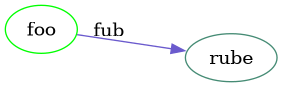

In [4]:
if __name__ == "__main__":
    from IPython.display import display
    graph = Graph()
    graph.put("foo", "bar", "roo")
    graph.put("foo", "fub", "rub")
    graph.put("foo", "bar", "rube")
    assert str(graph.whole_graph()) == "[('foo', 'fub', 'rub'), ('foo', 'bar', 'rube')]"
    graph.drop("foo", "bar", "rube")
    graph.replace("foo", "fub", "rub", "rube")
    assert str(graph.whole_graph()) == "[('foo', 'fub', 'rube')]"
    display(graph.render())

In [5]:
class QuantumSystem:
    quantum_system_name = "DMA"
    graph = None
    t = 0
    
    @classmethod
    def get_system(cls, name):
        for system in cls.MetaSystem.all_metasystems():
            if system.__name__ == name:
                return system
        
        for system in cls.HyperSystem.all_hypersystems():
            if system.__name__ == name:
                return system
        
        for system in cls.System.all_systems():
            if system.__name__ == name:
                return system

        raise Exception(f"Unknown system: {name}")

    @classmethod
    def reset(cls):
        if cls.graph is not None:
            cls.graph.conn.close()
        cls.graph = Graph()
    
    @classmethod
    def whole_graph(cls):
        return cls.graph.whole_graph()

    @classmethod
    def add_entity(cls, entity, **relationships):
        for rel_name, rel_value in relationships.items():
            cls.graph.put(entity, rel_name, rel_value)

    @classmethod
    def get(cls, entity=None, edge_name=None, terminant=None):
        if edge_name is not None and type(edge_name) is type:
            edge_name = edge_name.__name__
        kwargs = {"start_node": entity, "edge_name": edge_name, "end_node": terminant}
        return cls.graph.get(**kwargs)
    
    @classmethod
    def put(cls, entity, edge_name, terminant):
        if type(edge_name) is type:
            edge_name = edge_name.__name__
        cls.graph.put(entity, edge_name, terminant)
    
    @classmethod
    def drop(cls, entity, edge_name, terminant):
        if type(edge_name) is type:
            edge_name = edge_name.__name__
        cls.graph.drop(entity, edge_name, terminant)
    
    @classmethod
    def replace(cls, entity, edge_name, old_terminant, new_terminant):
        if type(edge_name) is type:
            edge_name = edge_name.__name__
        cls.graph.replace(entity, edge_name, old_terminant, new_terminant)
    
    @classmethod
    def validate(cls):
        results = {}
        for system in list(cls.System.all_systems()) + list(cls.HyperSystem.all_hypersystems()):
            try:
                system.validate()
            except Exception as exc:
                    results[system.__name__] = exc
        return results
    
    @classmethod
    def render(cls):
        return cls.graph.render()

qs = QuantumSystem

In [6]:
@dataclass
class Entity:
    """ An Entity is an anchor onto which Systems and HyperSystems attach """
    entity: str


class System:
    """ Systems describe relationships between nouns """
    
    @classmethod
    def all_systems(cls):
        for subclass in cls.__subclasses__():
            yield from subclass.all_systems()
            yield subclass
    
    @classmethod
    def validate(cls, terminant):
        return terminant
    
    @classmethod
    def build_system(cls, anchor, terminant):
        validated = cls.validate(terminant)
        QuantumSystem.add_entity(anchor, **{cls.__name__: validated})
        return anchor
    
    @classmethod
    def get_relationship(cls, entity):
        try:
            return QuantumSystem.get(entity, cls)[0][2]
        except IndexError:
            return None

    @classmethod
    def get_all_relationships(cls):
        return QuantumSystem(edge_name=cls)
    
    @classmethod
    def set_relationship(cls, entity, terminant):
        existing = cls.get_relationship(entity)
        if existing is not None:
            QuantumSystem.drop(entity, cls, cls.validate(existing))
        cls.build_system(entity, terminant)

    class RelationshipDoesNotExist(Exception):
        """ Exception for Non-existent Relationships """
    
    @classmethod
    def decorator(cls, entity_name=None, returned_name=None):
        entity_name = entity_name or "entity"
        returned_name = returned_name or cls.__name__.lower()
    
        def decorator(func):
            def wrapped(*args, **kwargs):
                # TODO: use inspection to identify arguments out of *args instead of just kwargs
                if cls.__name__.lower() not in kwargs:
                    entity = kwargs[entity_name]
                    try:
                        rel_value = cls.get_relationship(entity)
                    except Exception as e:
                        raise cls.RelationshipDoesNotExist(f"Failed to retrieve {cls.__name__} relationship on {entity}") from e
                    kwargs[returned_name] = cls.get_relationship(entity)
                return func(*args, **kwargs)
            return wrapped
        return decorator

    @classmethod
    def d(cls, func):
        return cls.decorator()(func)

    @classmethod
    def system_decorator(cls, system):
        setattr(system, cls.__name__, cls)
        if system.systems is None:
            system.systems = [cls]
        else:
            system.systems.append(cls)
        return system

    @classmethod
    def sd(cls, system):
        return cls.system_decorator(system)
    
    
class HyperSystem:
    """ HyperSystems describe relationships between relationships of nouns """
    systems = None
    
    @classmethod
    def all_hypersystems(cls):
        for subclass in cls.__subclasses__():
            yield from subclass.all_hypersystems()
            yield subclass

    @classmethod
    def system_edges(cls):
        edges = []
        for sys in cls.systems:
            if issubclass(sys, HyperSystem):
                edges.extend(sys.system_edges())
            else:
                edges.append(sys)
        return edges
    
    @classmethod
    def get_relationship(cls, entity):
        return QuantumSystem.get(entity, cls.system_edges())

    @classmethod
    def get_entities(cls):
        return QuantumSystem.get(edge_name=cls.system_edges())
    
    @classmethod
    def validate(cls):
        [system.validate() for system in cls.systems]
    
    @classmethod
    def build_system(cls, anchor, terminants: list | dict):
        # print(f"Building system: {cls} on {anchor} with {terminants}")
        if isinstance(terminants, dict):
            try:
                terminant_tuples = []
                for sys in cls.systems:
                    terminant_tuples.append((sys, terminants[sys.__name__]))
                terminants = terminant_tuples
            except KeyError as ke:
                raise Exception(f"Missing terminant for {sys.__name__}") from ke
        else:
            terminants = list(zip(cls.systems, terminants))
            if len(terminants) != len(cls.systems):
                print(f"Got {terminants}")
                print(f"Have systems: {cls.systems}")
                raise Exception(f"Missing terminants for {[sys.__name__ for sys in cls.systems[len(terminants):]]}")
        for system, terminant in terminants:
            if terminant is not None:
                system.build_system(anchor, terminant)
        return anchor

    @classmethod
    def system_decorator(cls, system):
        setattr(system, cls.__name__, cls)
        if system.systems is None:
            system.systems = [cls]
        else:
            system.systems.append(cls)
        return system

    @classmethod
    def sd(cls, system):
        return cls.system_decorator(system)


class MetaSystem:
    """ MetaSystems encapsulate HyperSystems and Systems """
    systems = None
    
    @classmethod
    def all_metasystems(cls):
        for subclass in cls.__subclasses__():
            yield from subclass.all_metasystems()
            yield subclass
    
    @classmethod
    def get_edge_names(cls):
        return [system.get_edge_name() for system in cls.systems]

    @classmethod
    def meta_anchor(cls, anchor):
        return f"{anchor}-{cls.__name__}"  
    
    @classmethod
    def build_system(cls, anchor, terminants):
        # print(f"Building: {cls} -- {anchor} -- {terminants}")
        meta_anchor = cls.meta_anchor(anchor)
        if isinstance(terminants, dict):
            try:
                terminant_tuples = []
                for sys in cls.systems:
                    terminant_tuples.append((sys, terminants[sys.__name__]))
                terminants = terminant_tuples
            except KeyError as ke:
                raise Exception(f"Missing terminant for {sys.__name__}") from ke
        else:
            terminants = list(zip(cls.systems, terminants))
            if len(terminants) != len(cls.systems):
                raise Exception(f"Missing terminants for {[sys.__name__ for sys in cls.systems[len(terminants):]]}")
        
        for system, terminant in terminants:
            system.build_system(meta_anchor, terminant)
        QuantumSystem.add_entity(anchor, **{cls.__name__: meta_anchor})
        return meta_anchor

    @classmethod
    def system_decorator(cls, system):
        setattr(system, cls.__name__, cls)
        if system.systems is None:
            system.systems = [cls]
        else:
            system.systems.append(cls)
        return system

    @classmethod
    def sd(cls, system):
        return cls.system_decorator(system)

In [7]:
class IntegerSystem(System):
    """ Simple Integer System """
    @classmethod
    def get_relationship(cls, entity):
        rel = super().get_relationship(entity)
        if rel is not None:
            return int(super().get_relationship(entity))
        return None

    @classmethod
    def validate(cls, terminant):
        return str(int(terminant))

In [8]:
class IntegerArraySystem(System):
    """ Simple Integer Array System """
    @classmethod
    def get_relationship(cls, entity):
        rel = super().get_relationship(entity)
        if rel is not None:
            return json.loads(super().get_relationship(entity))
        return None

    @classmethod
    def validate(cls, terminant):
        return json.dumps([int(d) for d in terminant])

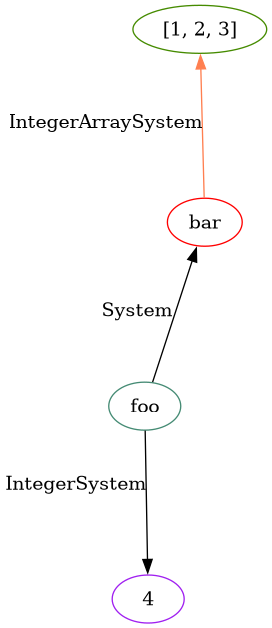

In [9]:
if __name__ == "__main__":
    qs.reset()
    System.build_system("foo", "bar")
    IntegerSystem.build_system("foo", 4)
    IntegerArraySystem.build_system("bar", [1, 2, 3])
    display(qs.render())

In [10]:
if __name__ == "__main__":
    assert QuantumSystem.get(edge_name=System) == [('foo', 'System', 'bar')]
    assert System.get_relationship("foo") == "bar"
    assert IntegerSystem.get_relationship("foo") == 4
    assert IntegerArraySystem.get_relationship("bar") == [1, 2, 3]
    assert System.get_relationship("DNE") is None